# Predicting the result of NHL games

This study is the attempt to apply the skill rating systems, such as ELO or TrueSkill to the prediction of NHL games. There were several competitions held by Kaggle on this topic, e.g. [Predicting Chess Ratings](https://www.kaggle.com/c/chess) and I will try to repeat some of the methods applied by winners.

I will start by representing teams as single players and assign the skill to the team as a whole using different ELO and TrueSkill rating systems. Since TrueSkill allows to model the rating of teams using the individial rating of players I may extend the model later on by considering every individual NHL player.

## Dataset

I have the NHL games database starting from 2005, when the league eliminated the tie games. The other major rule change happened in 2015/16 season with the introduction of 3 on 3 overtime and we will see the impact of this change on the model later in this notebook. But let's look at the data first.

In [67]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


#loading teamstats
ts = pd.read_pickle('team_stats_by_game')

#cleaning the dataset
ts['gameIdSeason'] = ts.apply(lambda x: int(str(x.gameId)[-4:]),axis=1)
ts['gameTypeId'] = ts["gameTypeId"].astype("category").cat.rename_categories(["Regular","Playoffs"])
ts['gameDate'] = ts.apply(lambda x: pd.to_datetime(x.gameDate, format='%Y-%m-%dT%H:%M:%SZ'), axis=1)

#show the structure
print(ts[ts.gameId == 2005020001])

       gameId gameLocationCode  faceoffWinPctg  faceoffsLost  faceoffsWon  \
0  2005020001                H          0.5645            27           35   
1  2005020001                R          0.4354            35           27   

             gameDate  gamesPlayed  goalsAgainst  goalsFor  losses  \
0 2005-10-05 23:00:00            1             2         1       1   
1 2005-10-05 23:00:00            1             1         2       0   

       ...      shotsAgainst  shotsFor  teamAbbrev        teamFullName  \
0      ...                21        30         BOS       Boston Bruins   
1      ...                30        21         MTL  Montréal Canadiens   

   teamId  ties  wins  seasonId  gameTypeId  gameIdSeason  
0       6     0     0      2005     Regular             1  
1       8     0     1      2005     Regular             1  

[2 rows x 29 columns]


Each "gameId" has two records for each opponent. A large number of the parameters is dependent and there is a lot of duplication, however I prefer to keep the separate row for each of the opponents later. Also a decent number of parameters is available including faceoff, powerplay and penalty killing statistics, obviously a number of goals for each opponent, the date and location of the game, season and overtime indicator.

In [68]:
print("Unique games:",ts.gameId.unique().shape[0])
print("Unique teams:",ts.teamId.unique().shape[0])

Unique games: 13968
Unique teams: 32


## Vanilla ELO

First let's apply the "vanilla" ELO with default parameters and no optimizations. The team with the highest pre-game ELO rating is predicted to be a winner. Overtime wins are treated in a same way as a main time ones. No home arena bonus is applied. To do this let's define the function to calculate the ELO ratings.

In [69]:
# process the database and calculate ELO rating for one season
def process_elo_forward(df,season,eloHomeBonus=0,eloOTDiscount=0,eloDelta=200.,eloMean=1500.,eloKFactor=16):
    
    # create a new dataframe for a given season
    dfs = df[df.seasonId == season].copy().set_index(['gameId','gameLocationCode'])

    # init new columns
    dfs['preGameELO'] = -1.0
    dfs['postGameELO'] = -1.0
    dfs['gamePredict'] = -1.0
    dfs['gameResult'] = -1.0
    dfs['accuracy'] = 0.0

    # loop over games
    gameList = dfs.index.levels[0].unique()
    teamList = dfs.teamAbbrev.unique()
    initAssign = True
    for gId in gameList:
        
        #assign initial value eloMean at the beginning of the season
        if initAssign: #do only once
            for team in teamList:
                teamGames = dfs[dfs.teamAbbrev == team]      
                fg = teamGames.iloc[0]
                dfs.loc[fg.name,'preGameELO'] = eloMean
            initAssign = False
        
        # get team names and pre-ELO
        hTeam = dfs.loc[(gId,'H'),'teamAbbrev']
        rTeam = dfs.loc[(gId,'R'),'teamAbbrev']
        hELO = dfs.loc[(gId,'H'),'preGameELO']
        rELO = dfs.loc[(gId,'R'),'preGameELO']

        # calculate the expected outcome of the game
        dpower = (rELO - hELO - eloHomeBonus)/eloDelta/2.
        expHome = 1.0/(1.0+np.power(10,dpower))
        dfs.loc[(gId,'H'),'gamePredict'] = 1.0/(1.0+np.power(10,dpower))
        dfs.loc[(gId,'R'),'gamePredict'] = 1.0/(1.0+np.power(10,-dpower))
        
        # get game result
        homeWin = dfs.loc[(gId,'H'),'wins']
        roadWin = dfs.loc[(gId,'R'),'wins']
        homeOTLoss = dfs.loc[(gId,'H'),'otLosses']
        roadOTLoss = dfs.loc[(gId,'R'),'otLosses']

        # actual result for home team
        if (homeWin == 1):
            realHome = 1.0
        elif (roadWin == 1):
            realHome = 0.0
        
        # check for overtime and apply discount
        if (homeOTLoss == 1):
            realHome = 1.0-eloOTDiscount
        elif (roadOTLoss == 1):
            realHome = eloOTDiscount
        
        # actual outcome of the game
        dfs.loc[(gId,'H'),'gameResult'] = realHome
        dfs.loc[(gId,'R'),'gameResult'] = 1.0 - realHome

        # post-game ELO rating
        deltaHome = eloKFactor*(realHome-expHome)
        dfs.loc[(gId,'H'),'postGameELO'] = hELO + deltaHome
        dfs.loc[(gId,'R'),'postGameELO'] = rELO - deltaHome

        # calculate naive accuracy
        if (dfs.loc[(gId,'H'),'gameResult'] > 0.5) & (dfs.loc[(gId,'H'),'gamePredict'] > 0.5):
            dfs.loc[(gId,'H'),'accuracy'] = 1.0
            dfs.loc[(gId,'R'),'accuracy'] = 1.0
        elif (dfs.loc[(gId,'H'),'gameResult'] < 0.5) & (dfs.loc[(gId,'H'),'gamePredict'] < 0.5):
            dfs.loc[(gId,'H'),'accuracy'] = 1.0
            dfs.loc[(gId,'R'),'accuracy'] = 1.0
        
        # assign forward to a new preGameELO
        homeTeamFuture = dfs[(dfs.teamAbbrev == hTeam) &\
            (dfs.index.get_level_values('gameId') > gId)]
        roadTeamFuture = dfs[(dfs.teamAbbrev == rTeam) &\
            (dfs.index.get_level_values('gameId') > gId)]
        
        if len(homeTeamFuture) > 0:
            homeIdx = homeTeamFuture.iloc[0].name
            dfs.loc[homeIdx,'preGameELO'] = hELO + deltaHome
        
        if len(roadTeamFuture) > 0:
            roadIdx = roadTeamFuture.iloc[0].name
            dfs.loc[roadIdx,'preGameELO'] = rELO - deltaHome

    return dfs

Now the function may be applied to generate a result for one of the seasons.

In [109]:
#calculating ELO for one season
df = process_elo_forward(ts,2005)
df.postGameELO.describe()

count    2626.000000
mean     1503.918169
std        50.190529
min      1355.763067
25%      1473.739396
50%      1505.484862
75%      1535.851446
max      1656.664633
Name: postGameELO, dtype: float64

And to verify the result here is the heatmap of the post-game ELO rating for each of the game by month for 2005 season.

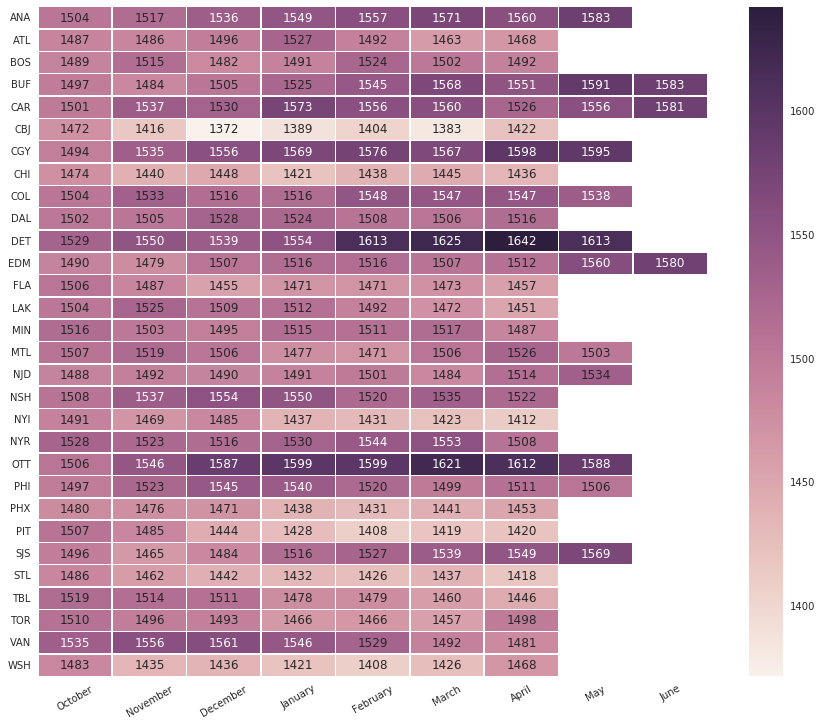

In [133]:
# Building heatmap for ELO by month
df = df.set_index(df.gameDate)
df['gameMonth'] = df.apply(lambda x: x.index.strftime('%B'))

# df = df.set_index(df.gameDate)
# df['gameMonth'] = df.apply(lambda x: x.index.strftime('%B'))

# Heatmap
hmap = df.groupby([pd.TimeGrouper(freq='M'),df.teamAbbrev]).agg({'postGameELO':np.mean}).reset_index()
hmap = hmap.pivot('teamAbbrev','gameDate', "postGameELO")

# Draw a heatmap with the numeric values in each cell
plt.figure(figsize=(15, 12))
ax = sns.heatmap(hmap, annot=True, fmt=".0f", linewidths=.5)
ax.set_xlabel("")
ax.set_ylabel("")
tlabels = ax.set_xticklabels(hmap.columns.strftime('%B'),rotation=30)

Looking at the plot above it is worth mentioning that Carolina (CAR) won Stanley cup defeating Edmonton (EDM) in playoffs. At the same time during the regular season Detroit and Ottawa led their corresponding conferences. The heatmap clearly supports this.

It is however just proves that ELO is calculated correctly and represents actual results. How about the predictive capabilities? There are two strategies here. One is naive and just assumes that if the expected match outcome based on the difference of ELO of two teams is above 0.5 we'd predict a win and vice versa. This is already implemented in the function which calculates ELO above and the overall accuracy of such naive approach may be calculated. The summary is below.

In [8]:
print(pd.pivot_table(df,values='accuracy',index=['gameTypeId'],aggfunc=np.mean))

gameTypeId
Regular     0.539837
Playoffs    0.493976
Name: accuracy, dtype: float64


The accuracy is 53.9% for regular season and 49.4% for playoffs. The low accuracy for playoffs may be explained by the fact that I didn't reset the ELO rating at the beginning of playoffs, so all losses of the teams with high ELO from the regular season introduced the additional error. One can clear see it on the heatmap as the teams who approached play-offs with high ELO rating from the main season didn't go any further.

Summary of this section: ** the vanilla ELO in this example added 4 percent points to the accuracy which is an 8% increase over random guess**. Now, let's try to optimize ELO even further by adding extra parameters and some classifier to predict game result based on the ELO.

## Optimized ELO

There are two obvious parameters which may be added to improve accuracy. One is the effect of the home arena and second the discount for overtime loss. First, the home bonus.

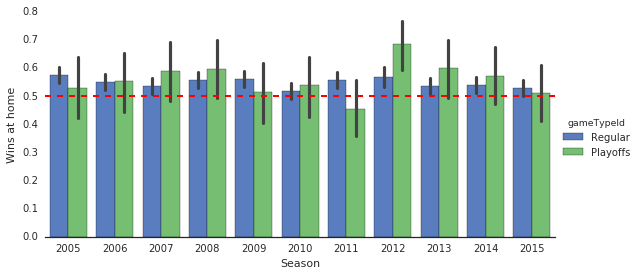

In [9]:
# Percentage of wins at thome
sns.set_style("white")
g = sns.factorplot(x="seasonId", y="wins", hue="gameTypeId", data=ts[ts.gameLocationCode=='H'],
                   size=4, aspect=2, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Wins at home")
g.set_xlabels("Season")
plt.axhline(y=0.5,color='r',ls='--',lw=2)

The plot above shows that home bonus may be quite significant especially during the regular season as it is above 0.5 with 95% CI for almost all seasons. For playoffs it looks like there is no definite effect. The idea is to add the homebonus directly to the pre-game ELO rating of the home team and this is done already in the function above.

The idea behind overtime loss discount is somewhat different. The post-game ELO factor is updated using the difference between expected and actual result (or between expected skill and actual result). By adding a discount to overtime loss I am minimizing the loss of ELO rating for the team which lost in overtime.

I obtained the optimal values of home bonus and OT discount by processing all seasons separately by running the two-parameter search with mean accuracy as the objective function.

In [148]:
eloParams = pd.read_csv("elo_optim_params.csv").set_index('seasonId')
eloParams.target = 1.0-eloParams.target
print(eloParams)

          homeBonus  otDiscount    target
seasonId                                 
2005      65.362500    0.672750  0.607768
2006      63.000000    0.724500  0.580473
2007      62.606250    0.735281  0.544487
2008      68.512500    0.720187  0.577069
2009      63.123047    0.653883  0.568613
2010      68.709375    0.756844  0.533738
2011      58.275000    0.629625  0.561550
2012      63.787500    0.707250  0.590571
2013      63.000000    0.724500  0.576720
2014      63.000000    0.724500  0.559515
2015      50.295410    0.760600  0.548092


and then breaking them in training and test dataset and doing the two-parameter search with mean accuracy as the objective function. The training set consisted of five seasons - 2006, 2008, 2010, 2012 and 2014. I will not repeat the optimization in this notebook as it took quite some time to run 30 iterations. The optimized parameters didn't change for the last 10 or iterations and they are the following.

It is interesting that 2015 appeared to have a better naive accuracy with different parameter set than all other seasons. Comparing to parameters obtained using all other seasons the **2015 season has a smaller home bonus and higher overtime loss discount**. One way to explain it is that losing in overtime with the new 3-on-3 rule has lesser impact on the ELO rating of the loser or that 3-on-3 is more random, if you will. At the same time it is the only season with the new rule and to evaluate whether the difference is significant I'd have to run optimization for each of 11 seasons and then compare the differences between optimized parameters to test the hypothesis of whether 2015 season is significantly different.

In [11]:
df = process_elo_forward(ts,2005,eloHomeBonus=homeBonus,eloOTDiscount=otDiscount)

In [12]:
print(pd.pivot_table(df,values='accuracy',index=['gameTypeId'],aggfunc=np.mean))

gameTypeId
Regular     0.609756
Playoffs    0.518072
Name: accuracy, dtype: float64


This is quite an improvement. And these are the parameters not fitted to 2005 season. The naive ELO accuracy is almost 61%, which is 22% better than random guess. Let's calculate the performance for all seasons with the same parameters to establish the benchmark going forward.

In [13]:
for season in np.arange(2006,2016):
    df = pd.concat([df,process_elo_forward(ts,season,eloHomeBonus=homeBonus,eloOTDiscount=otDiscount)])

Before we review the accuracy let's look at the heatmap for all teams throughout all seasons. I will build the heatmap for the mean values of postGameELO throughout the season for each team.

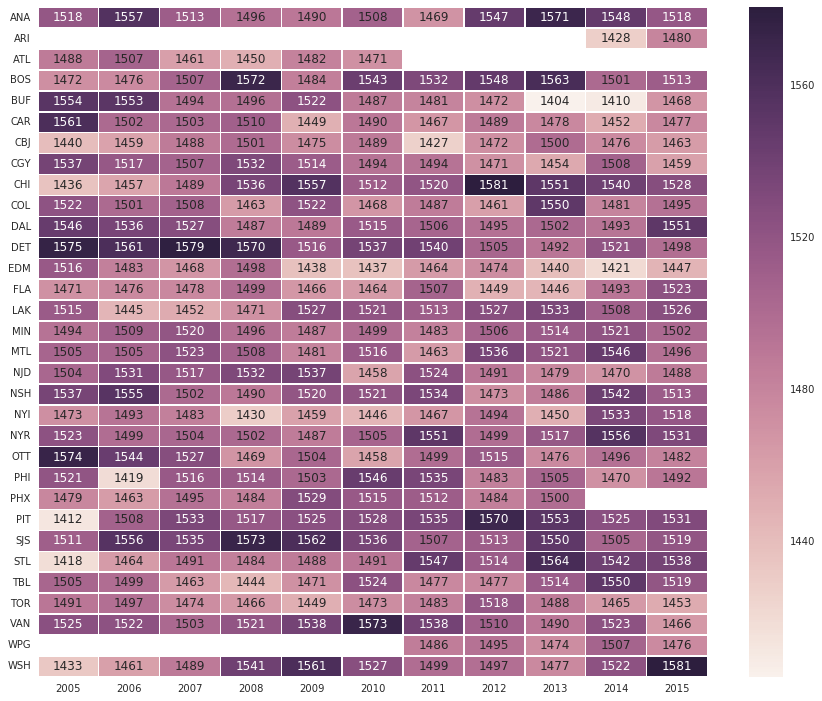

In [14]:
# Create a heatmap mean seasonal ELO ratings
hmap = df.groupby(['teamAbbrev','seasonId']).agg({'postGameELO':np.mean}).reset_index()
hmap = hmap.pivot('teamAbbrev','seasonId', "postGameELO")

# Draw a heatmap with the numeric values in each cell
plt.figure(figsize=(15, 12))
ax = sns.heatmap(hmap, annot=True, fmt=".0f", linewidths=.5)
ax.set_xlabel("")
ax.set_ylabel("")

The image above is good summary of all NHL team performances in the last eleven years. Now let's return to evaluating the predictive capabilities of ELO. 

In [15]:
print(pd.pivot_table(df,values='accuracy',index=['seasonId'],columns=['gameTypeId'],aggfunc=np.mean))

gameTypeId   Regular  Playoffs
seasonId                      
2005        0.609756  0.518072
2006        0.581301  0.555556
2007        0.534959  0.600000
2008        0.573171  0.632184
2009        0.565041  0.516854
2010        0.534959  0.528090
2011        0.551220  0.465116
2012        0.577778  0.697674
2013        0.565854  0.602151
2014        0.556098  0.595506
2015        0.531707  0.525000


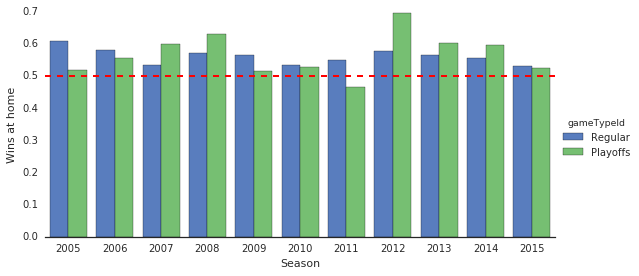

In [16]:
# Factor plot for percentage of wins at home
sns.set_style("white")
g = sns.factorplot(x="seasonId", y="accuracy", hue="gameTypeId", data=df,
                   size=4, aspect=2, kind="bar", palette="muted", ci=None)
g.despine(left=True)
g.set_ylabels("Wins at home")
g.set_xlabels("Season")
plt.axhline(0.5, color='r', ls='--', lw=2)

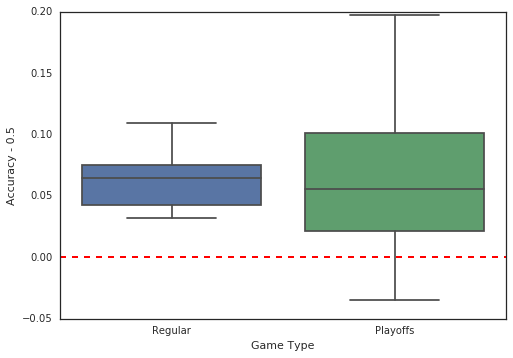

In [17]:
# calculate accuracy by season and gametype
acc=df.groupby(['seasonId','gameTypeId']).agg({'accuracy':np.mean}).reset_index()
acc.accuracy = acc.accuracy - 0.5
# make a boxplot
sns.set_style("white")
ax = sns.boxplot(x="gameTypeId", y="accuracy", data=acc)
ax.set_xlabel("Game Type")
ax.set_ylabel("Accuracy - 0.5")
acc[acc.gameTypeId=='Regular'].accuracy.median()
plt.axhline(0, color='r', ls='--', lw=2)

The last two plots show the distribution of accuracy over different game types and seasons. The **median gain of accuracy over random guess for regular season games is 6.5 percent points and for playoffs is 5.6 percent points**. Playoffs case has two extremes with 2012 playoffs accuracy as high as 69% and 2011 playoffs accuracy of 46.5%.

## Optimized ELO with Classifier

The previous section covered the naive approach to predicting the outcome of the games. The Kaggle competion showed, however, that it is possible to improve the accuracy by training a classifier to predict the outcome of the game based on the ELO rating of opponents. As a first step let's make a training set. For the training set I need each game to be represented by one row, so I need to flatten the structure of the dataframe.

In [18]:
# reset indices
df_elo = df.reset_index()
df_elo = df_elo.set_index(['gameId','gameLocationCode'])
# unstack and create multiindex columns
df_elo = df_elo.unstack(level=-1)
# convert to array and back to dataframe with columns as tuples
df_elo = pd.DataFrame(df_elo.to_records())
# slice and rename columns
df_elo = df_elo[["('preGameELO', 'R')","('preGameELO', 'H')","('gameResult', 'R')","('gameResult', 'H')",'gameId']]
df_elo.columns = ['preGameELOHome','preGameELORoad','gameResultHome','gameResultRoad','gameId']

# final touch - create a new factorized variable
df_elo.loc[df_elo.gameResultHome>0.5,'result'] = 'H'
df_elo.loc[df_elo.gameResultRoad>0.5,'result'] = 'R'
# df_elo.loc[(df_elo.gameResultHome>0.5) & (df_elo.gameResultHome < 1.0),'result'] = 'otH'
# df_elo.loc[(df_elo.gameResultRoad>0.5) & (df_elo.gameResultRoad < 1.0),'result'] = 'otR'
[df_elo['resultFct'],factors] = df_elo['result'].factorize()

Now we can split the set and train some classifier, e.g. Random Forest.

In [19]:
# selecting only required columns
X = df_elo[['preGameELOHome','preGameELORoad']]
y = df_elo['resultFct']

from sklearn import ensemble
from sklearn import learning_curve
from sklearn import cross_validation
from sklearn import metrics
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.33, random_state=42)

# training the model
model = ensemble.RandomForestClassifier(n_estimators=5)
model.fit(X_train,y_train)

# calculating learning curves
train_sizes, train_scores, test_scores = learning_curve.learning_curve(model,
            X, y, cv=10, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# calculate confusion matrix
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)

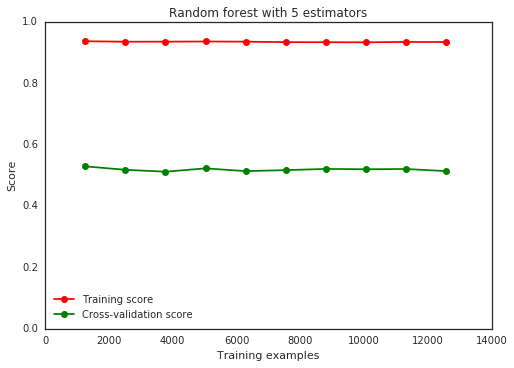

In [20]:
# plot the learning curve
plt.figure()
plt.title("Random forest with 5 estimators")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim([0,1.0])
plt.plot(train_sizes, train_scores_mean,'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc=3)

In [21]:
def plot_confusion_matrix(cm, factors, title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(factors.shape[0])
    plt.xticks(tick_marks, factors)
    plt.yticks(tick_marks, factors)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

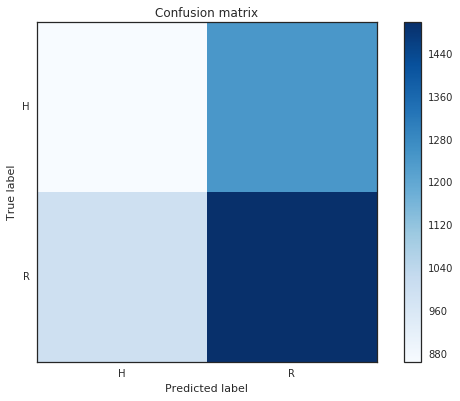

In [22]:
plot_confusion_matrix(cm,factors)

## Vanilla TrueSkill

## References